## TO-DO
- Implement object detection
- Fix losses (I think)
- Learning rate optimisations
- Evaluation (metrics)

In [1]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
from utils.loader import DataLoader
import matplotlib.pyplot as plt
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: " , len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
batch_size = 32

In [3]:
loader = DataLoader(batch_size)
img_ds = loader.get_image_ds().repeat()
masks_ds = loader.get_mask_ds().repeat()
label_ds = loader.get_binary_ds().repeat()
bbox_ds = loader.get_bboxes_ds().repeat()

In [4]:
img_height, img_width, channels = list(img_ds.take(1))[0].shape[-3:]

Plot some examples (Ignore if training)

In [5]:
# Make some examples
examples = tf.data.Dataset.zip((img_ds, masks_ds, label_ds, bbox_ds)).as_numpy_iterator()
# examples = label_ds.as_numpy_iterator()

In [6]:
display_list = next(examples)
# np.sum(display_list)

In [7]:
# box_img1 = tf.image.draw_bounding_boxes(tf.cast(tf.expand_dims(display_list[0][0,...], 0),dtype=tf.float32), fix_bbox(display_list[3][0]).reshape([1,1,4])/256, np.array([[255, 0, 0]]),name=None)
# img = Image.fromarray(np.uint8(tf.squeeze(box_img1).numpy()), 'RGB')
# img
# # 

In [8]:
def fix_bbox(bbox):
    temp = np.zeros_like(bbox)
    temp[0], temp[1] = bbox[1], bbox[0]
    temp[2], temp[3] = bbox[3], bbox[2]
    return temp

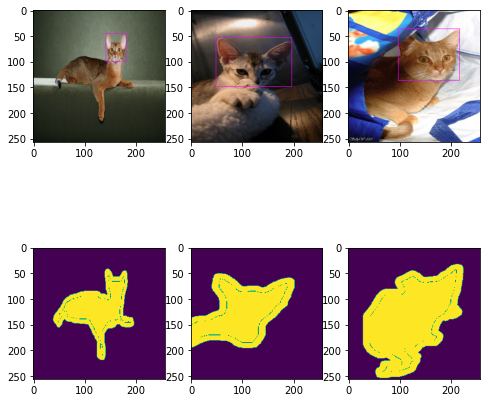

In [9]:
# View some examples
# display_list = next(examples)
fig, (ax1, ax2) = plt.subplots(2, 3, figsize=(8,8))
for i in range(3):
    box_img = tf.image.draw_bounding_boxes(tf.cast(tf.expand_dims(display_list[0][i,...], 0),dtype=tf.float32), fix_bbox(display_list[3][i]).reshape([1,1,4])/256, np.array([[255.0, 0.0, 255]]))
    ax1[i].imshow(Image.fromarray(np.uint8(tf.squeeze(box_img)), 'RGB'))
    ax2[i].imshow((display_list[1][i,...]))

Build our MTL

In [10]:
#Augment training data to reduce overfitting by creating a pre-proccessing layer that only activates in training

data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"), #random hor flip
        tf.keras.layers.experimental.preprocessing.RandomFlip("vertical"), # random ver flip
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.5), #random rotation up to 180deg
        # tf.layers.experimental.preprocessing.RandomZoom((0,-.75)), #up to 75% zoom
    ]
)

In [11]:
# Build base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, input_shape=[img_height, img_width, 3], weights='imagenet'
)

In [12]:
# Picked each final decoding layer in the EffNet architecture
layer_names = [
    'block2a_expand_activation',
    'block3a_expand_activation',
    'block4a_expand_activation',
    'block6a_expand_activation',
    'block7a_project_conv'
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs, name='Encoder')
encoder.trainable = False

In [13]:
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [14]:
def upsample_block(filters, size):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.ReLU())

  return result

In [28]:
# Build the up-sampler
inputs = tf.keras.layers.Input(shape=[img_height, img_width, 3])

# Downsampling through the model
skips = encoder(inputs)
x = skips[-1]
inter = skips[-1] # Save for output to binary classifier
skips = reversed(skips[:-1])

up_stack = [
    upsample_block(512, 3),
    upsample_block(256, 3),
    upsample_block(128, 3),
    upsample_block(64, 3), 
]

# Upsampling and establishing the skip connections
for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

# Our multiple outputs
seg_out = tf.keras.layers.Conv2DTranspose(
    filters=3, kernel_size=3, strides=2,
    padding='same', name='segnet_out')(x)

bin_class_out = tf.keras.layers.GlobalAveragePooling2D(name='bin_class_pooling')(inter)
bin_class_out = keras.layers.Dense(2, activation='softmax', name='bin_class_out')(bin_class_out)

model = tf.keras.Model(inputs=inputs, outputs=[seg_out, bin_class_out])


In [30]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Encoder (Functional)            [(None, 128, 128, 96 3633571     input_5[0][0]                    
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 16, 16, 512)  1476608     Encoder[3][4]                    
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 16, 16, 1184) 0           sequential_11[0][0]              
                                                                 Encoder[3][3]              

Test out model

In [17]:
# def generator_img():
#     a = img_ds.as_numpy_iterator()
#     b = masks_ds.as_numpy_iterator()
#     c = label_ds.as_numpy_iterator()
#     d = bbox_ds.as_numpy_iterator()
#     while True: # Add shuffling
#         X = a.next()
#         Y1 = b.next()
#         Y2 = c.next()
#         Y3 = d.next()
#         # Regularisation/augmentation
#         X = data_augmentation(X, training=True)
        
#         yield X, [Y1, Y2, Y3]
def generator_img():
    a = img_ds.as_numpy_iterator()
    b = masks_ds.as_numpy_iterator()
    c = label_ds.as_numpy_iterator()
    while True: # Add shuffling
        X = a.next()
        Y1 = b.next()
        Y2 = c.next()
        # Regularisation/augmentation
        # X = data_augmentation(X, training=True)
        
        yield X, [Y1, Y2]

In [18]:
b = generator_img()
a = next(b)
i = 0

In [19]:
seg_pred, bin_pred = model.predict(a[0][i][tf.newaxis,...])
seg_max = tf.argmax(seg_pred, axis=-1)
seg_max = seg_max[..., tf.newaxis][0]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,12))
ax1.imshow(Image.fromarray(np.uint8(tf.squeeze(a[0][i,...])))) #Image.fromarray(np.uint8(tf.squeeze(box_img).numpy()), 'RGB')
ax2.imshow(a[1][0][i,...])
ax3.imshow(seg_max)
print(f'Dog: {bin_pred[0][0]},   Cat: {bin_pred[0][1]}') # 0 is dog, 1 is cat
i += 1

KeyboardInterrupt: 

Train model

In [ ]:
#keras.optimizers.Adam(4.3e-5) Errors here?
model.compile(optimizer=keras.optimizers.Adam(),
              loss={'segnet_out' : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    'bin_class_out' : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
              metrics=['accuracy'])

In [ ]:
model.fit(generator_img(),epochs=10, steps_per_epoch=2000//16)

Epoch 1/10
125/125 [==============================] - 100s 773ms/step - loss: 0.7948 - segnet_out_loss: 0.3956 - bin_class_out_loss: 0.3992 - segnet_out_accuracy: 0.6103 - bin_class_out_accuracy: 0.5059
Epoch 2/10
 17/125 [===>..........................] - ETA: 1:11 - loss: 0.2168 - segnet_out_loss: 0.1478 - bin_class_out_loss: 0.0690 - segnet_out_accuracy: 0.5857 - bin_class_out_accuracy: 0.4629

KeyboardInterrupt: 